In [45]:
import sys
import os
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats
import scripts.get_namelist as nml

dtheta_inc = 0.018

def which_tID(tvec,t):
    tID = np.argmin(np.abs(tvec-t))
    return tID

def growth_rates(filename_prefix):
    fname = filename_prefix+'growth.dat'
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)

    nstats=3
    dat = np.reshape(dat,[n/nstats,nstats])
    time = dat[:,0]
    dtheta = dat[:,1]
    domega = dat[:,2]
    return time,dtheta,domega    

# Make linear fit
def linear_fit(time,dtheta,tstart,tend,verbose=True):
    ts = which_tID(time,tstart)
    te = which_tID(time,tend)
    t_fit = time[ts:te]
    dat_fit = dtheta[ts:te]
    growth_rate,shift = np.polyfit(t_fit, dat_fit, 1) #linear fit
    if verbose:
        #print("Fitting between times {}-{} (steps {}-{})".format(time[ts],time[te],ts,te))
        print("dtheta growth: {} - {}".format(dtheta[ts],dtheta[te]))
        print("domega growth: {} - {}".format(domega[ts],domega[te]))
        print("dtheta growth rate: {}".format(growth_rate))
        print("dtheta/dtheta_inc growth rate: {}".format(growth_rate/dtheta_inc))
    return t_fit,growth_rate,shift


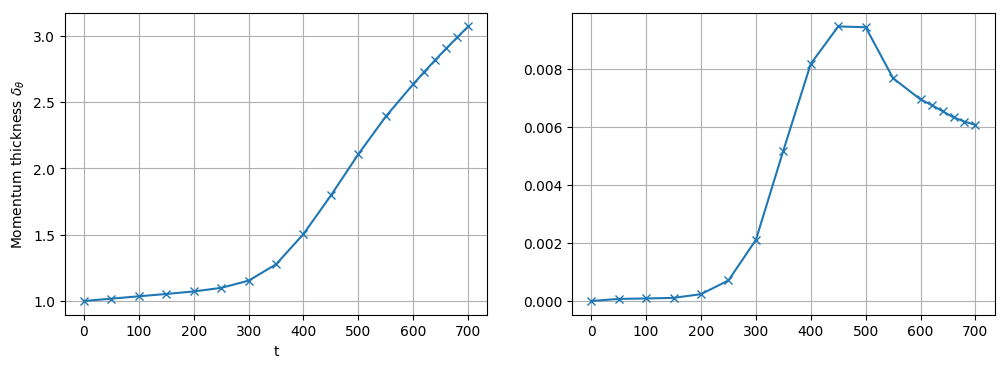

In [46]:
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/512x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/256x512x128/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc07/rr1/724x1024x362/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/512x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/724x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr_7/1024x1448x512/'

filename_prefix = directory+'/shearlayer_'
time,dtheta,rate = growth_rates(filename_prefix)

fig, axarr = plt.subplots(1,2, figsize=(12,4), dpi=100) 
axarr[0].plot(time,dtheta,'-x'); axarr[0].grid(True);
axarr[0].grid(True)
axarr[0].set_xlabel('t')
axarr[0].set_ylabel(r'Momentum thickness $\delta_\theta$')
axarr[0].grid(True)
axarr[1].plot(time,rate,'-x')
axarr[1].grid(True)

In [47]:
# linear fit
t_fit,growth_rate,shift = linear_fit(time,dtheta,tstart=600,tend=700,verbose=True)

# Plotting
fig, axarr = plt.subplots(1,2, figsize=(12,4), dpi=200) 
axarr[0].plot(time,dtheta,'-')
axarr[0].plot(t_fit,t_fit*growth_rate+shift,'k-x',alpha=0.5)

axarr[1].plot(time,rate,'-x')
axarr[1].grid(True)
axarr[1].set_xlabel('t')
axarr[1].set_ylabel(r'$\dot{\delta}_\theta$')


#dtheta_inc = 0.018#0.5798895658492144

# clean plots
axarr[0].grid(True)
axarr[0].set_xlabel('t')
axarr[0].set_ylabel(r'Momentum thickness $\delta_\theta$')

inp = nml.inputs(directory,verbose=True)
print('\tdu = {}'.format(inp.du))
growth_rate/dtheta_inc/(inp.du)
print(rate[-1]/dtheta_inc)

dtheta growth: 2.63666259037 - 3.07143283069


IndexError: index 12 is out of bounds for axis 0 with size 9

0.006806544119911225
0.005700005216908484
0.004573713275232599


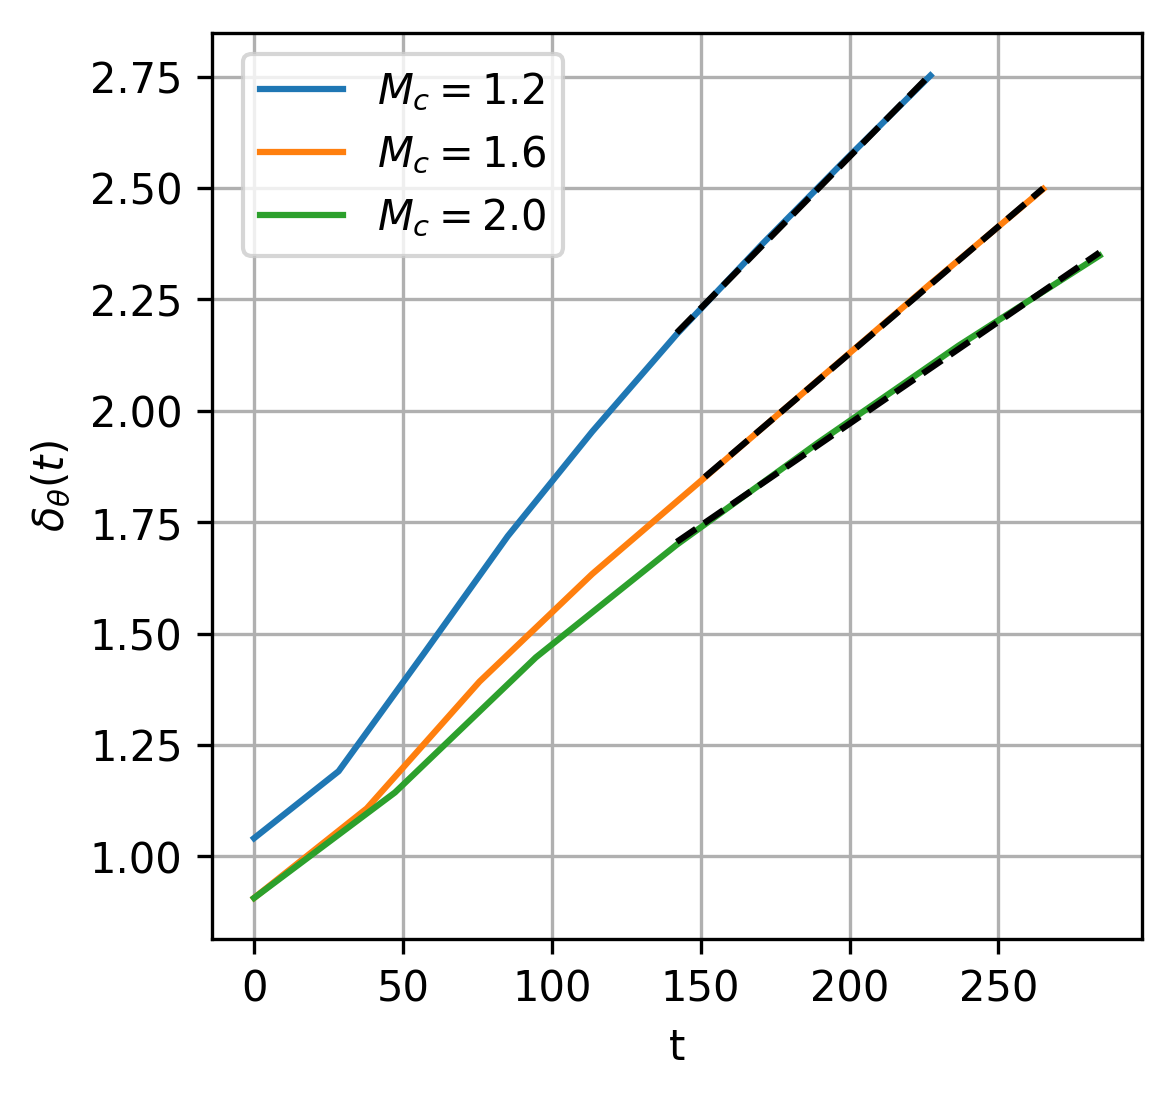

In [116]:
#Do for multiple:

# Plotting
fig = plt.figure(figsize=(4,4), dpi=300) 

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=False)
time,dtheta,domega = growth_rates(directory+'shearlayer_')
time *= inp.du
t_fit,growth_rate,shift = linear_fit(time,dtheta,tstart=150,tend=max(time),verbose=False)
plt.plot(time,dtheta,'-',label='$M_c = 1.2$')
plt.plot(t_fit,t_fit*growth_rate+shift,'k--')
print(growth_rate)

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=False)
time,dtheta,domega = growth_rates(directory+'shearlayer_')
time *= inp.du
t_fit,growth_rate,shift = linear_fit(time,dtheta,tstart=150,tend=max(time),verbose=False)
plt.plot(time,dtheta,'-',label='$M_c = 1.6$')
plt.plot(t_fit,t_fit*growth_rate+shift,'k--')
print(growth_rate)

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=False)
time,dtheta,domega = growth_rates(directory+'shearlayer_')
time *= inp.du
t_fit,growth_rate,shift = linear_fit(time,dtheta,tstart=150,tend=max(time),verbose=False)
plt.plot(time,dtheta,'-',label='$M_c = 2.0$')
plt.plot(t_fit,t_fit*growth_rate+shift,'k--')
print(growth_rate)

plt.xlabel('t')
#plt.xlim([0,2000])
#plt.ylim([0,18])
plt.grid(True)
plt.ylabel(r'$\delta_{\theta}(t)$')
plt.legend(bbox_to_anchor=(0.4, 1.0))